This notebook produces the plots for the main text of the photon noise paper.

In [1]:
save_pdf = True
save_eps = True

In [2]:
import os
import pandas as pd
from scipy.constants import h, pi
import matplotlib as mpl
print(mpl.matplotlib_fname())
#from kid_readout.analysis import archive, dataframe, plot_dataframe
plt.rcParams['font.size'] = 11

/home/flanigan/notebooks/mkid/2016_NESSF/matplotlibrc


# Load data

In [3]:
cw = pd.DataFrame(np.load('continuous-wave.npy'))
bb = pd.DataFrame(np.load('broadband.npy'))

# Select data

In [4]:
cw_max_name = 'cw20_ampfreebincut10prop'
cw_max_short = 'afbc10p'
bb_max_name = 'bb20_ampfreebincut10prop'
bb_max_short = 'afbc10p'

In [5]:
cw_NEP2_key = 'source_power_fd_{}_NEP2_device'.format(cw_max_short)
bb_NEP2_key = 'source_power_fd_{}_NEP2_device'.format(bb_max_short)

# Functions

In [6]:
def common(df, key):
    s = set(df[key])
    if len(s) > 1:
        raise ValueError("Multiple values for {}".format(key))
    else:
        return s.pop()


def histogram(ax, bins, values, **kwargs):
    x = np.zeros(2 * bins.size)
    y = np.zeros(x.size)
    x[0::2] = x[1::2] = bins
    y[1:-2:2] = y[2:-1:2] = values
    ax.plot(x, y, **kwargs)
    return x, y


def float_to_latex(f):
    if np.log10(f) < -15:
        unit = 'aW'
        scale = 1e6
    elif np.log10(f) < -12:
        unit = 'fW'
        scale = 1e3
    else:
        unit = 'pW'
        scale = 1
    scaled = 1e12 * scale * f
    precision = 2 - int(np.floor(np.log10(scaled)))
    format_string = '{{:.{}f}} {{}}'.format(precision)
    return format_string.format(scaled, unit)


def white_noise_model(f, series):
    W2 = series.noise_fit_device_noise
    A2 = series.noise_fit_amplifier_noise
    f_c = series.noise_fit_fc
    return W2 / (1 + (f / f_c)**2) + A2


def pink_noise_model(f, series, key):
    W2 = series['{}_white'.format(key)]
    A2 = series['{}_amp'.format(key)]
    f_c = series['{}_invtau'.format(key)]
    f_k = series['{}_fknee'.format(key)]
    alpha = series['{}_alpha'.format(key)]
    return W2 * (1 + (f / f_k)**(-alpha)) / (1 + (f / f_c)**2) + A2

In [7]:
eta_bb = common(bb, 'eta')
B_bb = common(bb, 'B')

eta_cw = common(cw, 'eta')

single_channel = common(bb, 'channel')
#atten = 29
nu_cw = common(cw, 'timestream_mmw_source_freq')
nu_bb = 150e9

In [8]:
noise_colormap = plt.cm.RdYlBu_r
cw_color = 'saddlebrown' #'darkgoldenrod'
bb_color = 'darkgreen'
cw_marker = 's'
bb_marker = 'o'
cw_label = "continuous-wave"
bb_label = "broadband"

Sx_scale = 1e18
noise_ylimits = (Sx_scale * 1e-19, Sx_scale * 3e-15)
noise_xlimits = (1e1, 1e4)

PA_scale = 1e12
X_scale = 1e6
PA_limits = (8e-4, 6e1)
X_limits = (1e-1, 1e3)
NEPA_limits = (1e-18, 1e-15)
PA_line = np.logspace(np.log10(PA_limits[0]), np.log10(PA_limits[1]), 1e3) / PA_scale
to_aWrtHz = 1e18

In [9]:
mappable_cw = plt.cm.ScalarMappable(matplotlib.colors.LogNorm(min(cw.source_power), max(cw.source_power)),
                                    cmap=noise_colormap)
mappable_cw.set_array(cw.source_power)

mappable_bb = plt.cm.ScalarMappable(matplotlib.colors.LogNorm(min(bb.source_power), max(bb.source_power)),
                                    cmap=noise_colormap)
mappable_bb.set_array(bb.source_power)

# NEP vs P

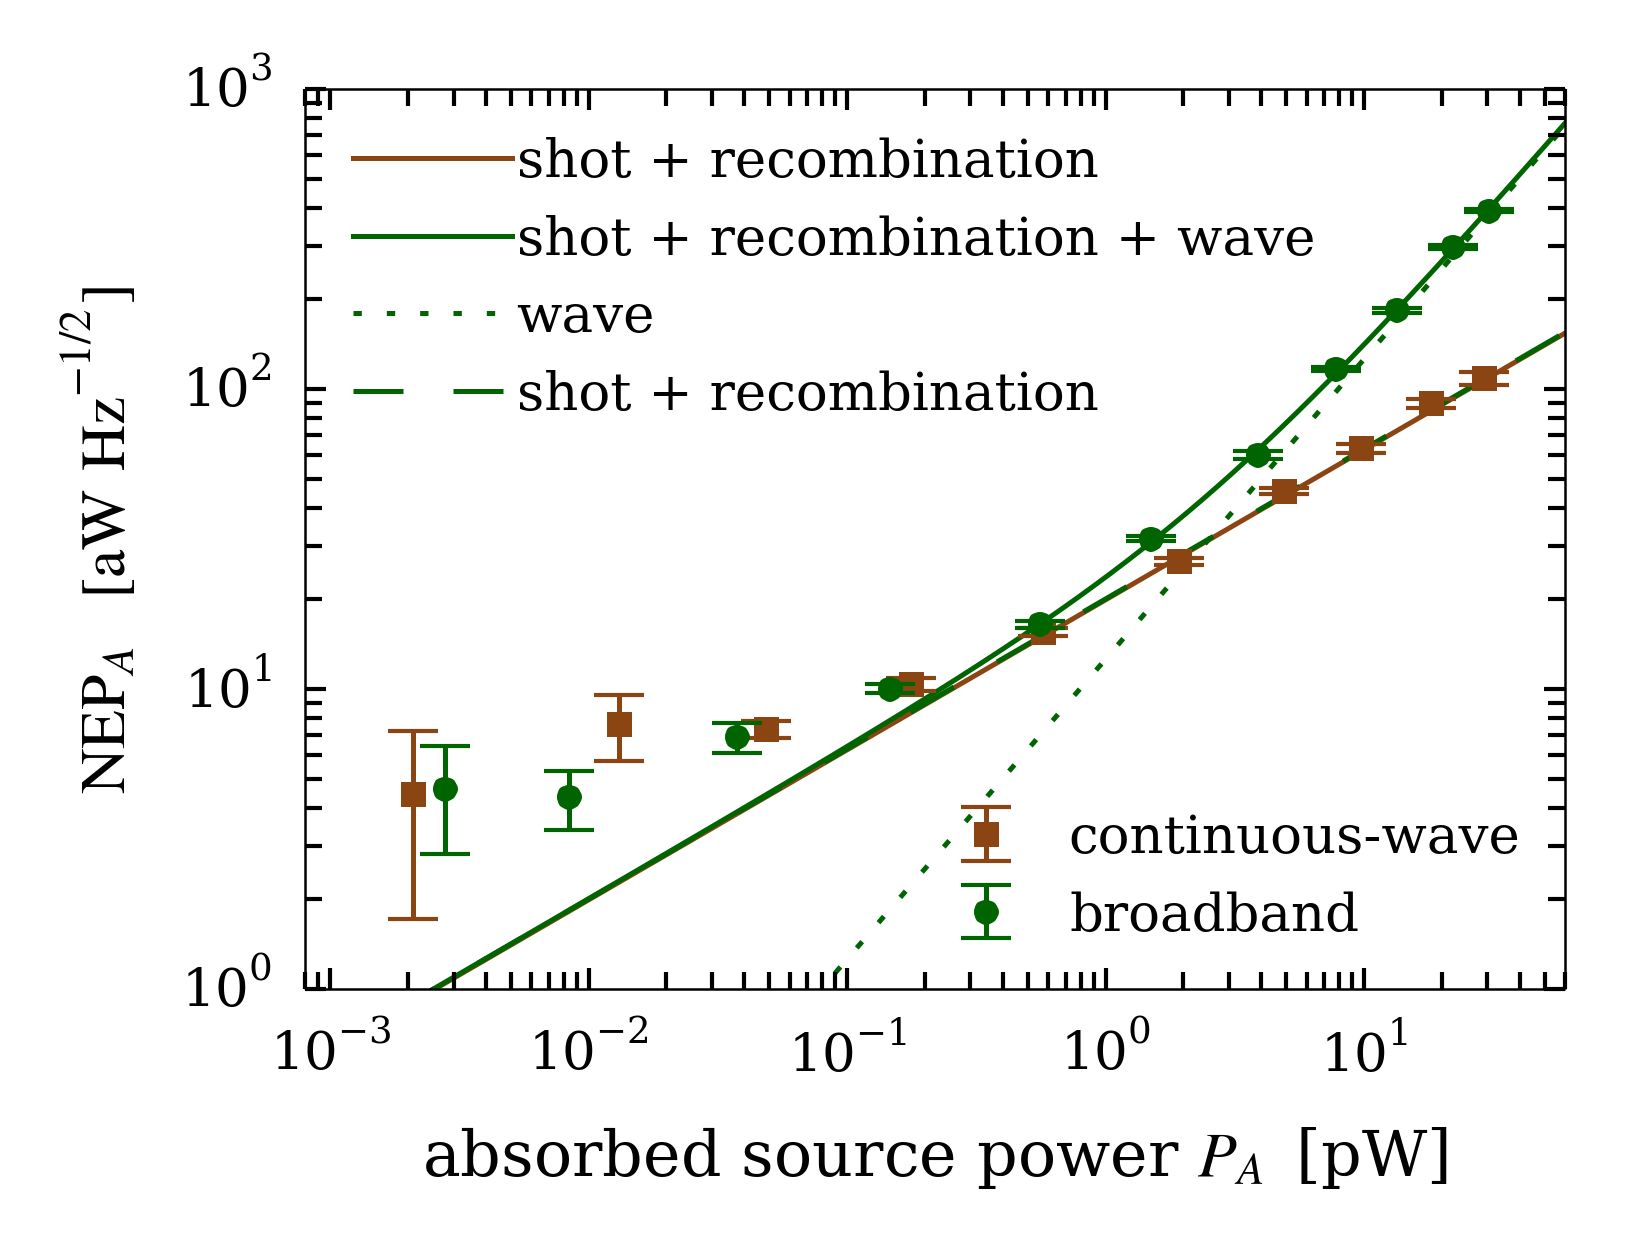

In [17]:
fig, ax = plt.subplots()

# NEP
NEP_cw = eta_cw * cw[cw_NEP2_key]**(1/2)
NEP_cw_err = NEP_cw * (1/2) * (cw[cw_NEP2_key + '_err'] / cw[cw_NEP2_key])
NEP_bb = eta_bb * bb[bb_NEP2_key]**(1/2)
NEP_bb_err = NEP_bb * (1/2) * (bb[bb_NEP2_key + '_err'] / bb[bb_NEP2_key])

# 0
ax.plot(PA_scale * PA_line,
        to_aWrtHz * (4 * h * nu_cw * PA_line)**(1/2),
        '-', color=cw_color, label='shot + recombination')  # r'$(4 h \nu P_A)^{1/2}$')

# 1
ax.plot(PA_scale * PA_line,
        to_aWrtHz * (4 * h * nu_bb * PA_line)**(1/2),
        '--', color=bb_color, label='shot + recombination')  # r'$(4 h \nu P_A)^{1/2}$')

# 2
ax.plot(PA_scale * PA_line,
        to_aWrtHz * (2 * PA_line**2 / B_bb)**(1/2),
        ':', color=bb_color, label='wave')  # r'$(2 P_A^2 / B)^{1/2}$')
# 3
ax.plot(PA_scale * PA_line,
        to_aWrtHz * (4 * h * nu_bb * PA_line + 2 * PA_line**2 / B_bb)**(1/2),
        '-', color=bb_color, label='shot + recombination + wave')  # r'$(4 h \nu P_A + 2 P_A^2 / B)^{1/2}$')
    
ax.errorbar(PA_scale * eta_cw * cw.source_power,
            to_aWrtHz * NEP_cw,
            yerr=to_aWrtHz * NEP_cw_err,
            marker=cw_marker, markeredgecolor='none', linestyle='none',
            color=cw_color, label=cw_label)

ax.errorbar(PA_scale * eta_bb * bb.source_power,
            to_aWrtHz * NEP_bb,
            yerr=to_aWrtHz * NEP_bb_err,
            marker=bb_marker, markeredgecolor='none', linestyle='none',
            color=bb_color, label=bb_label)

ax.set_xlabel('absorbed source power $P_A$ [pW]')
ax.set_ylabel(r'$\mathrm{NEP}_A \; [\mathrm{aW} \, \mathrm{Hz}^{-1/2}]$')
ax.set_xlim(*PA_limits)
ax.set_ylim(to_aWrtHz * NEPA_limits[0], to_aWrtHz * NEPA_limits[1]);
ax.set_yscale('log', nonposy='clip')
ax.set_xscale('log')
nep_handles, nep_labels = ax.get_legend_handles_labels()
order = [0, 3, 2, 1]
ax.add_artist(ax.legend([nep_handles[n] for n in order],
                        [nep_labels[n] for n in order], loc='upper left', fontsize='xx-small'))
ax.legend(nep_handles[4:6], nep_labels[4:6], loc='lower right', fontsize='xx-small')

if save_pdf:
    fig.savefig('results.pdf', pad_inches=0.01)
if save_eps:
    fig.savefig('results.eps', pad_inches=0.01)

In [20]:
from scipy.constants import h, k as k_B
T = 2.725
nu = 150e9
fb = 0.3
B = fb * nu
n = 1 / (np.exp((h * nu) / (k_B * T)) - 1)
P = h * nu * B * n
1e12 * P

0.34303675495778962

In [21]:
# Aluminum
T_c = 1.2
nu_gap = 2 * 1.76 * k_B * T_c / h
1e-9 * nu_gap

88.01387413141818

In [23]:
# Niobium
T_c = 9.2
nu_gap = 2 * 1.76 * k_B * T_c / h
1e-9 * nu_gap

674.7730350075392

In [25]:
# NbTiN
T_c = 15
nu_gap = 2 * 1.76 * k_B * T_c / h
1e-9 * nu_gap

1100.173426642727